In [1]:
import os
import shutil
from glob import glob
import yaml
import json
from sklearn.model_selection import train_test_split
from tqdm import tqdm

base_dir = "solo"
output_dir = "dataset"   # ← 출력 디렉터리 지정

# 1. 모든 이미지/라벨 파일 목록 수집
image_paths = sorted(glob(os.path.join(base_dir, "sequence.*", "step*.camera.png")))
json_paths  = sorted(glob(os.path.join(base_dir, "sequence.*", "step*.frame_data.json")))

def get_key(path):
    folder = os.path.basename(os.path.dirname(path))
    name = os.path.basename(path).split('.')[0]  # step0
    return f"{folder}_{name}"

image_map = {get_key(p): p for p in image_paths}
json_map  = {get_key(p): p for p in json_paths}
common_keys = sorted(set(image_map.keys()) & set(json_map.keys()))

# train/val 분할 (2개 미만이면 모두 train)
if len(common_keys) < 2:
    train_keys = common_keys
    val_keys = []
else:
    train_keys, val_keys = train_test_split(common_keys, test_size=0.2, random_state=42)

# 디렉토리 생성
for split in ['train', 'val']:
    os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)

IMG_W = 640
IMG_H = 640

def process_data(keys, split):
    for k in tqdm(keys):
        img_src = image_map[k]
        img_dst = os.path.join(output_dir, 'images', split, f"{k}.png")
        shutil.copy2(img_src, img_dst)
        json_src = json_map[k]
        with open(json_src, "r") as f:
            data = json.load(f)
        lines = []
        for capture in data['captures']:
            for ann in capture['annotations']:
                if ann['@type'].endswith('BoundingBox2DAnnotation'):
                    for obj in ann['values']:
                        x, y = obj['origin']
                        w, h = obj['dimension']
                        pts = [
                            x, y,
                            x + w, y,
                            x + w, y + h,
                            x, y + h
                        ]
                        pts_norm = []
                        for i, p in enumerate(pts):
                            if i % 2 == 0:  # x
                                pts_norm.append(str(round(p / IMG_W, 6)))
                            else:           # y
                                pts_norm.append(str(round(p / IMG_H, 6)))
                        line = "0 " + " ".join(pts_norm)
                        lines.append(line)
        txt_dst = os.path.join(output_dir, 'labels', split, f"{k}.txt")
        with open(txt_dst, "w") as f:
            f.write("\n".join(lines))

process_data(train_keys, 'train')
process_data(val_keys, 'val')

# data.yaml 생성
data_yaml = {
    'train': 'images/train',
    'val': 'images/val',
    'nc': 1,
    'names': ['car']
}
with open(os.path.join(output_dir, 'data.yaml'), 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"완료: train {len(train_keys)}개, val {len(val_keys)}개. data.yaml이 {output_dir}에 저장됨.")


100%|██████████| 2000/2000 [00:19<00:00, 104.70it/s]

완료: train 8000개, val 2000개. data.yaml이 dataset에 저장됨.


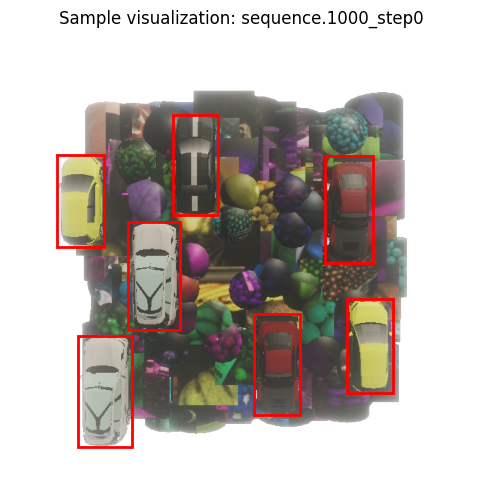

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# 설정
IMG_W = 640
IMG_H = 640
label_dir = 'dataset/labels/train'
image_dir = 'dataset/images/train'

# 시각화할 샘플 하나 선택
sample_name = None
for fname in os.listdir(label_dir):
    if fname.endswith('.txt'):
        sample_name = os.path.splitext(fname)[0]
        break

if not sample_name:
    raise FileNotFoundError("시각화할 라벨 파일이 없습니다.")

label_path = os.path.join(label_dir, f"{sample_name}.txt")
image_path = os.path.join(image_dir, f"{sample_name}.png")

# 이미지 불러오기
img = Image.open(image_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)
ax = plt.gca()

# 라벨 읽기 및 박스 그리기
with open(label_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 9:
            continue
        _, *pts = map(float, parts)
        xs = pts[0::2]
        ys = pts[1::2]
        min_x = min(xs) * IMG_W
        min_y = min(ys) * IMG_H
        max_x = max(xs) * IMG_W
        max_y = max(ys) * IMG_H
        rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

plt.axis('off')
plt.title(f"Sample visualization: {sample_name}")
plt.show()
